In [1]:
import math
import numpy as np
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit import IBMQ
import matplotlib
%matplotlib inline

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
def loadQuantumImage(path):
    from PIL import Image
    image= Image.open(path)
    (width, height) = image.size
    pixels = image.load()

    ssum = 0
    for i in range(width):
        for j in range(height):
            ssum += pixels[i,j]**2

    m = math.floor(math.log(height, 2))
    n = math.floor(math.log(width, 2))
    stateVector = np.zeros(2**(m+n))
    for i in range(width):
        for j in range(height):
            stateVector[i*height + j] = pixels[i,j]/math.sqrt(ssum)
            
    return stateVector, m, n

In [3]:
def exportQuantumImage(counts, shots, height, width):
    from PIL import Image

    r = math.floor(math.log(width, 2))
    im= Image.new("L", (width, height))
    pixels = im.load()

    maxAmplitude = 256
    medAmplitude = maxAmplitude/2
    med = shots/(height * width)
    for key in counts:
        i = int(key[0:r], 2)
        j = int(key[r:], 2)
        val = round((((counts[key] - med)/med)*medAmplitude) + medAmplitude)
        pixels[i,j] = (val)
        
    return im

In [4]:
def Increment(increment, quantumRegister, circuit):
    from qiskit.aqua.components.qfts import Standard as qft
    from qiskit.aqua.components.iqfts import Standard as iqft
    
    n = len(quantumRegister)
    
    qft(n).construct_circuit(qubits=quantumRegister,circuit=circuit)
    
    for j in range(n):
        circuit.u1((np.pi*increment)/(2**(n-1-j)), quantumRegister[j])
        
    iqft(n).construct_circuit(qubits=quantumRegister,circuit=circuit)
    

In [5]:
def Rotate(rowReg, columnReg, circuit):
    circuit.x(rowReg)
    circuit.x(columnReg)

In [6]:
def Transpose(rowReg, columnReg, circuit):
    m = rowReg.size
    n = columnReg.size
    
    if (n != m):
        raise "Can only transpose square images" 
    
    for i in range(n):
        circuit.swap(rowReg[i], columnReg[i])

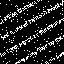

In [113]:
from qiskit.aqua.components.qfts import Standard as qft
stateVector, m, n = loadQuantumImage('Images\Documents\claim1_30dg_inverted_64.bmp')
#stateVector, m, n = loadQuantumImage('lena32.png')

state = [complex(x) for x in stateVector]
indexes = range(m+n)

columnReg = QuantumRegister(n)
rowReg = QuantumRegister(m)
creg = ClassicalRegister(n+m)

circ = QuantumCircuit(rowReg, columnReg, creg)
circ.initialize(state, indexes)

#qft(m).construct_circuit(qubits=rowReg,circuit=circ)
#qft(n).construct_circuit(qubits=columnReg,circuit=circ)
#qft(n+m).construct_circuit(qubits=circ.qubits,circuit=circ)

#Increment(2**(n-1), rowReg, circ)
#Increment(2**(m-1), columnReg, circ)

circ.measure(indexes, indexes)

provider = IBMQ.get_provider(group='open')
localSimulator = Aer.get_backend('qasm_simulator')
backend = provider.get_backend('ibmq_qasm_simulator')

shots = 1024 # 2**(m+n)*10 # 8190
result = execute(circ, localSimulator, shots=shots).result()
counts = result.get_counts(circ)
counts, m, n
            
exportedImg = exportQuantumImage(counts, shots, 2**m, 2**n)
exportedImg

In [107]:
sortedCounts = sorted(counts.items(), key=lambda kv: kv[1])
sortedCounts.reverse()
mappedSortedCounts = [((int(c[0][0:n], 2), int(c[0][n:], 2)), c[1]) for c in sortedCounts]

minOffset = 2**(m-2)-2**(m-3) 

def hasMinimumOffset(point1, point2, minOffset):
    colDif = np.abs(point1[0] - point2[0])
    if (colDif >= minOffset):
        return True
    lineDif = np.abs(point1[1] - point2[1])
    if (lineDif >= minOffset):
        return True
    return False

def computeAngle(point1, point2):
    dx = np.abs(point1[1] - point2[1])
    dy = np.abs(point1[0] - point2[0])
    angle = np.arctan2(dy, dx)
    return np.rad2deg(angle)

angles = {}
used = []
rng = min(50, len(mappedSortedCounts)-1)
for i in range(rng):
    point1 = mappedSortedCounts[i][0]
    if (point1 in used):
        continue
    used.append(point1)
    for p2 in mappedSortedCounts[i+1:]:
        point2 = p2[0]
        if (point2 in used):
            continue
        if (hasMinimumOffset(point1, point2, minOffset)):
            used.append(point2)
            angle = np.round(computeAngle(point1, point2))
            angles[angle] = angles.get(angle, 0) + 1
            break

sortedAngles = sorted(angles.items(), key=lambda kv: kv[1])
sortedAngles.reverse()
sortedAngles   
    

[(9.0, 5),
 (11.0, 3),
 (8.0, 2),
 (7.0, 1),
 (4.0, 1),
 (84.0, 1),
 (25.0, 1),
 (40.0, 1),
 (41.0, 1),
 (77.0, 1),
 (20.0, 1),
 (13.0, 1),
 (34.0, 1),
 (5.0, 1),
 (16.0, 1),
 (21.0, 1),
 (14.0, 1),
 (10.0, 1)]

In [38]:
#exportedImg.save("fain.jpg")
counts.items()
mappedSortedCounts[0:]
np.round(3.4)
min(-20, 100, 400)

-20